logistic regression, decision tree, K-nearest neighbours, support vector machine, gradient boosting, random forest, artificial neural networks and deep neural networks have been applied in this domain

## Import the necessary libraries

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

## Load Datasets

In [3]:
# Load the datasets
triage_data = pd.read_csv('./dataset/triage.csv')
edstays_data = pd.read_csv('./dataset/edstays.csv')

In [4]:
# Merge the two datasets on the 'subject_id' and 'stay_id' columns
dataset = pd.merge(triage_data, edstays_data[['subject_id','stay_id','intime','disposition']], on=['subject_id','stay_id'])

In [5]:
dataset.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,intime,disposition
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension,2180-07-22 16:24:00,HOME
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention",2180-05-06 19:17:00,ADMITTED
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain",2180-08-05 20:58:00,ADMITTED
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention,2180-06-26 15:54:00,ADMITTED
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",2180-07-23 05:54:00,ADMITTED


In [6]:
# Count the amount of data before preprocessing
count_before = len(dataset)
print("Data before preprocessing: ", count_before)

Data before preprocessing:  425087


In [7]:
dataset.dropna(axis=0, how='any', inplace=True)

In [8]:
# check for null values
print(dataset.isnull().any())

subject_id        False
stay_id           False
temperature       False
heartrate         False
resprate          False
o2sat             False
sbp               False
dbp               False
pain              False
acuity            False
chiefcomplaint    False
intime            False
disposition       False
dtype: bool


In [9]:
mask = dataset['pain'].str.contains('___') #De-identified data

deidentified_rows = dataset[mask].index
dataset = dataset.drop(index=deidentified_rows)

dataset['pain'] = pd.to_numeric(dataset['pain'], errors='coerce') # Removing random text values from column
dataset.dropna(subset=['pain'], inplace=True)

In [10]:
# Count the amount of data after preprocessing
count_after = len(dataset)
print("Data after preprocessing: ", count_after)

Data after preprocessing:  380149


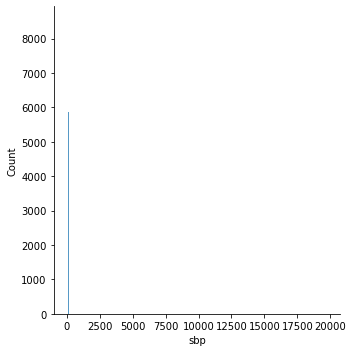

In [28]:
sns.displot(dataset['sbp'])

## Data Split - Diagnostic Stage

In [12]:
# Define the features and the target for the diagnostic stage
x_diagnosis = dataset[['temperature','heartrate','resprate','o2sat','sbp','dbp','pain']]
y_diagnosis = dataset['acuity']

In [13]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV

## Hyper-Parameter Tuning using GridSearchCV

In [15]:
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state' : [42]
}

In [16]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [42]})

In [17]:
rf_cv.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 42}

Best Parameters from GridSearchCV - {'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 42}

## Random Forest Model

In [29]:
# Train a Random Forest Classifier for the diagnostic stage
diagnosis = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=8, max_features='sqrt', random_state=42)
diagnosis.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=2000, random_state=42)

In [30]:
# Predict the acuity values for the test set
y_pred = diagnosis.predict(X_test)

# Check the accuracy of the diagnostic model
accuracy = diagnosis.score(X_test, y_test)
print("Accuracy of diagnostic stage: ", accuracy)

Accuracy of diagnostic stage:  0.5970800999605419


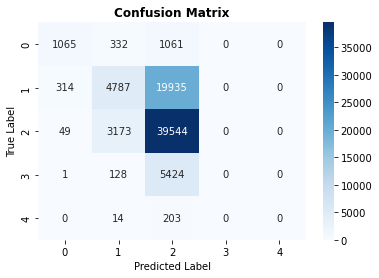

Accuracy score: 59.70800999605419
Recall score: [0.43327909 0.19120467 0.92465978 0.         0.        ]
Precision score: [0.74527642 0.56758359 0.59763931 0.         0.        ]
              precision    recall  f1-score   support

         1.0       0.75      0.43      0.55      2458
         2.0       0.57      0.19      0.29     25036
         3.0       0.60      0.92      0.73     42766
         4.0       0.00      0.00      0.00      5553
         5.0       0.00      0.00      0.00       217

    accuracy                           0.60     76030
   macro avg       0.38      0.31      0.31     76030
weighted avg       0.55      0.60      0.52     76030



C:\Users\hamma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\lib\site-packages\sklearn\metrics\_classifi

In [31]:
# creating a confusion matrix 
cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",  weight='bold')
plt.show()

#Printing Accuracy, Recall and Precision Scores
ac = accuracy_score(y_test, y_pred)
rs = recall_score(y_test, y_pred, average=None)
ps = precision_score(y_test, y_pred, average=None)
print("Accuracy score: " + str(ac*100))
print("Recall score: " + str(rs))
print("Precision score: " + str(ps))

# Print the evaluation of the model
print(classification_report(y_test, y_pred))

Before Parameter Tuning- Accuracy at 58%
After Parameter Tuning - Accuracy at 59% LMAO
After setting n_estimator from 500 to 1200 - accuracy at 60%